In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from collections import Counter
from wordcloud import WordCloud


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('/home/ro/PycharmProjects/My/Data setai/kickstarter-projects/ks-projects-201801.csv')

In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
df.shape

(378661, 15)

In [6]:
df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [7]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [8]:
df.dropna(axis = 0, inplace = True)
#axis means that we remowe rows with null values

In [9]:
df.shape

(374860, 15)

In [10]:
#lets check how many projects are successufl

def success_rate (df, state):
    x = pd.concat([df[state].value_counts(normalize = True) * 100,
    #normalize = True --> returns count devided by 374860(vhole df)
                  df[state].value_counts(normalize = False)], axis = 1)
    x = round(x, 2) #round up numbers
    #axis = 1 --> conacatinating columns
    x.columns = ['% of projects', 'count']
    return x

In [11]:
print(success_rate(df, 'state'))

            % of projects   count
failed              52.72  197611
successful          35.71  133851
canceled            10.34   38757
live                 0.75    2798
suspended            0.49    1843


In [12]:
#removing 'canceled', 'live', 'suspended' projects from data Frame
df.query("state in ['failed', 'successful']", inplace = True)

In [13]:
success_rate(df, 'state')

,% of projects,count
failed,59.62,197611
successful,40.38,133851


In [14]:
# select features

df = df.loc[:, ['name', 'category', 'main_category', 'deadline', 
                'usd_goal_real', 'launched', 'state', 'country']]

In [15]:
df.rename(columns={'usd_goal_real' : 'goal'}, inplace = True)

In [16]:
cat_success = success_rate(df, 'main_category')

In [17]:
cat_success.columns

Index(['% of projects', 'count'], dtype='object')

In [44]:
cat_success.index

Index(['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Art',
       'Design', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography',
       'Crafts', 'Journalism', 'Dance'],
      dtype='object')

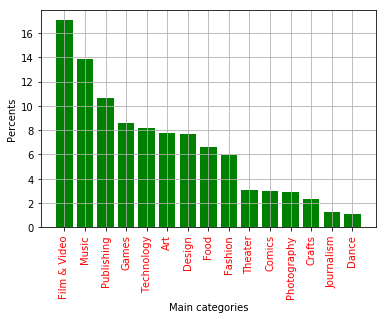

In [59]:
plt.bar(cat_success.index, cat_success['% of projects'], color = 'g')
plt.xlabel('Main categories')
plt.ylabel('Percents')
plt.xticks(np.arange(15), cat_success.index, rotation=90, color = 'r')
plt.grid(True)
#don't know  how to remove <matplotlib.axis.XTick at 0x7f37e18926d8> these..:(

In [185]:
df_country = success_rate(df, 'country').head()
df_country
#lets look at to 5 countrys by projects quentity

,% of projects,count
US,78.85,261358
GB,8.89,29453
CA,3.73,12370
AU,2.00,6616
DE,1.04,3436


In [272]:
df_country.iloc[0, 1]

261358

In [275]:
hist_indicator = 'success'
hist_country = 'US'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

us_success = df[mask1 & mask2]
us_success_percent = round(len(us_success)/df_country.iloc[0, 1]*100, 2)
us_success_percent

41.82

In [279]:
hist_indicator = 'success'
hist_country = 'GB'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

gb_success = df[mask1 & mask2]
gb_success_percent = round(len(gb_success)/df_country.iloc[1, 1]*100, 2)
gb_success_percent

40.97

In [282]:
hist_indicator = 'success'
hist_country = 'CA'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

ca_success = df[mask1 & mask2]
ca_success_percent = round(len(ca_success)/df_country.iloc[2, 1]*100, 2)
ca_success_percent

33.42

In [283]:
hist_indicator = 'success'
hist_country = 'AU'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

au_success = df[mask1 & mask2]
au_success_percent = round(len(au_success)/df_country.iloc[3, 1]*100, 2)
au_success_percent

30.38

In [284]:
hist_indicator = 'success'
hist_country = 'DE'

mask1 = df['state'].str.contains(hist_indicator)
mask2 = df['country'].str.contains(hist_country)

de_success = df[mask1 & mask2]
de_success_percent = round(len(de_success)/df_country.iloc[4, 1]*100, 2)
de_success_percent

27.27

In [254]:
#reik pazet kori salis yra sekmingiause pagal patvirtintus projektus
us_count = 0
gb_count = 0
ca_count = 0
au_count = 0
de_count = 0
y = 0
for i in range(0, len(df)):
    for country, state in df.iloc[i, 11], df.iloc[i, 9]:
        y += 1
    print(country, state)
#     if country == 'US' & state == 'success':
#         us_count += 1
#     elif df['country'] == 'GB' & df['state'] == 'success':
#         gb_count += 1
#     elif df['country'] == 'CA' & df['state'] == 'success':
#         ca_count += 1
#     elif df['country'] == 'AU' & df['state'] == 'success':
#         au_count += 1
#     elif df['country'] == 'DE' & df['state'] == 'success':
#         de_count += 1
#print(us_count)
    

IndexError: single positional indexer is out-of-bounds

In [146]:
money_goal = success_rate(df, 'goal').head(15)
money_goal

,% of projects,count
5000.0,6.46,21428
10000.0,5.54,18351
1000.0,3.59,11908
3000.0,3.46,11463
2000.0,3.26,10800
15000.0,3.03,10028
2500.0,2.69,8901
20000.0,2.66,8803
500.0,2.39,7935
1500.0,2.23,7403


In [180]:
sort_success = sorted(list(money_goal['count']), reverse = False)


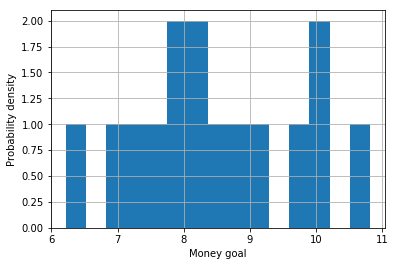

In [183]:
plt.hist(np.log1p(money_goal.index), bins = 15, log=False)
plt.xlabel('Money goal')
plt.ylabel('Probability density')
# plt.xticks()
# plt.yticks()
plt.grid(True)

Text(0.5, 0, '21428')

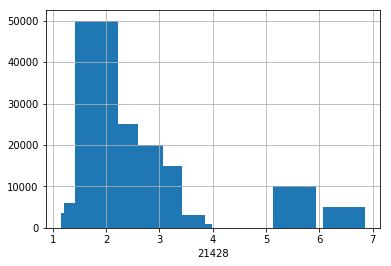

In [182]:
count = money_goal.index.values
percent = money_goal['% of projects'].values
#plt.hist(money_goal['count'])
plt.bar(percent, count)
plt.grid(True)
plt.xlabel(money_goal['count'].iloc[0])

In [47]:
df.goal.describe()

count    3.314620e+05
mean     4.152286e+04
std      1.109279e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: goal, dtype: float64

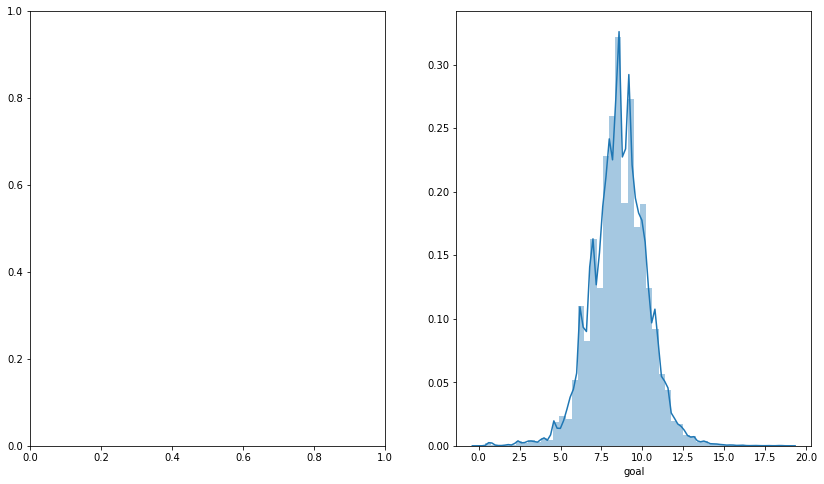

In [139]:
# combine different plots into one: goal and log(goal)
dims = (14, 8)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=dims)
#sns.distplot(df.goal, ax=ax1)
sns.distplot(np.log1p(df.goal), ax=ax2)

In [172]:
#convert launched and deadline to real date
df['lounched'] = pd.to_datetime(df.launched)
df['deadline'] = pd.to_datetime(df.deadline)
df = df.sort_values('launched')

In [173]:
df.head()

,name,category,main_category,deadline,goal,launched,state,country,lounched
169268,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,2009-05-31,1000.0,2009-04-21 21:02:48,failed,US,2009-04-21 21:02:48
322000,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,2009-07-20,80000.0,2009-04-23 00:07:53,failed,US,2009-04-23 00:07:53
138572,drawing for dollars,Illustration,Art,2009-05-03,20.0,2009-04-24 21:52:03,successful,US,2009-04-24 21:52:03
325391,Offline Wikipedia iPhone app,Software,Technology,2009-07-14,99.0,2009-04-25 17:36:21,successful,US,2009-04-25 17:36:21
122662,Pantshirts,Fashion,Fashion,2009-05-26,1900.0,2009-04-27 14:10:39,failed,US,2009-04-27 14:10:39
